In [19]:
import os
import tensorflow as tf
import numpy as np

DATA_DIR = "/content/datasets/training"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
AUTOTUNE = tf.data.AUTOTUNE
SAVE_PROCESSED = True
SAVE_DIR = "/content/processed_dataset"

tf.random.set_seed(SEED)
np.random.seed(SEED)

if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"❌ DATA_DIR not found: {DATA_DIR}")

image_formats = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
found_images = any(
    file.lower().endswith(image_formats)
    for root, _, files in os.walk(DATA_DIR)
    for file in files
)
if not found_images:
    raise ValueError(f"❌ No images found in directory {DATA_DIR} with allowed formats: {image_formats}")

total_val = VAL_SPLIT + TEST_SPLIT
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=total_val,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=total_val,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

temp_unbatched = temp_ds.unbatch()
total_temp = sum(1 for _ in temp_unbatched)
temp_unbatched = temp_ds.unbatch()
n_val = int((VAL_SPLIT / total_val) * total_temp)
n_test = total_temp - n_val

val_ds = temp_unbatched.take(n_val).batch(BATCH_SIZE)
test_ds = temp_unbatched.skip(n_val).batch(BATCH_SIZE)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("🟢 Classes detected:", class_names)
print("🟢 Num classes:", NUM_CLASSES)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1024).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.12),
    tf.keras.layers.RandomZoom(0.12),
    tf.keras.layers.RandomTranslation(0.06, 0.06)
], name="data_augmentation_layer")

def augment_dataset(ds):
    def _augment(image, label):
        return data_augmentation(image, training=True), label
    return ds.map(_augment, num_parallel_calls=AUTOTUNE)

train_ds_aug = augment_dataset(train_ds)

def dataset_count(ds):
    n = 0
    for batch in ds:
        n += len(batch[1])
    return n

print(f"🟢 Training batches: {len(list(train_ds))}, approx samples: {dataset_count(train_ds)}")
print(f"🟢 Validation batches: {len(list(val_ds))}, approx samples: {dataset_count(val_ds)}")
print(f"🟢 Test batches: {len(list(test_ds))}, approx samples: {dataset_count(test_ds)}")

if SAVE_PROCESSED:
    try:
        tf.data.experimental.save(train_ds, os.path.join(SAVE_DIR, "train"))
        tf.data.experimental.save(val_ds, os.path.join(SAVE_DIR, "val"))
        tf.data.experimental.save(test_ds, os.path.join(SAVE_DIR, "test"))
        print("🟢 Saved processed datasets to:", SAVE_DIR)
    except Exception as e:
        print("🟡 Warning: could not save datasets:", e)

print("🟢 Module 1 done. Exposed objects: train_ds, train_ds_aug, val_ds, test_ds, class_names, data_augmentation")

Found 87 files belonging to 4 classes.
Using 61 files for training.
Found 87 files belonging to 4 classes.
Using 26 files for validation.
🟢 Classes detected: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
🟢 Num classes: 4
🟢 Training batches: 4, approx samples: 61
🟢 Validation batches: 1, approx samples: 13
🟢 Test batches: 1, approx samples: 13
🟢 Saved processed datasets to: /content/processed_dataset
🟢 Module 1 done. Exposed objects: train_ds, train_ds_aug, val_ds, test_ds, class_names, data_augmentation


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, applications

IMG_SIZE = (224, 224, 3)
NUM_CLASSES = len(class_names)

BACKBONE = "DenseNet121"
FREEZE_BACKBONE = True

if BACKBONE == "DenseNet121":
    base_model = applications.DenseNet121(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
elif BACKBONE == "DenseNet169":
    base_model = applications.DenseNet169(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
else:
    base_model = applications.DenseNet201(weights='imagenet', include_top=False, input_shape=IMG_SIZE)

base_model.trainable = not FREEZE_BACKBONE

inputs = tf.keras.Input(shape=IMG_SIZE)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

if NUM_CLASSES == 2:
    outputs = layers.Dense(1, activation='sigmoid', name="classifier")(x)
    loss_fn = losses.BinaryCrossentropy()
    metrics = ['accuracy']
else:
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name="classifier")(x)
    loss_fn = losses.SparseCategoricalCrossentropy()
    metrics = ['accuracy']

model = models.Model(inputs, outputs, name=f"{BACKBONE}_transfer")

optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

try:
    model.summary()
    print("🟢 Model built and compiled successfully.")
except Exception as e:
    print("❌ Model summary failed:", e)

def unfreeze_model(model, n_unfreeze=20):
    try:
        base = model.get_layer(index=1)
        for layer in base.layers[-n_unfreeze:]:
            layer.trainable = True
        model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss=loss_fn, metrics=metrics)
        print(f"🟢 Unfroze last {n_unfreeze} layers and recompiled model.")
    except Exception as e:
        print("🟡 Warning: Could not unfreeze layers:", e)

print("🟢 Module 2 done. Exposed objects: model, unfreeze_model, base_model")


Model: "DenseNet121_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

🟢 Model built and compiled successfully.
🟢 Module 2 done. Exposed objects: model, unfreeze_model, base_model


Epoch 1/4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3004 - loss: 1.8511

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 1.67289, saving model to /content/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.2961 - loss: 1.8723 - val_accuracy: 0.3077 - val_loss: 1.6729 - learning_rate: 1.0000e-04
Epoch 2/4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3165 - loss: 1.9053
Epoch 2: val_loss improved from 1.67289 to 1.44478, saving model to /content/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.3220 - loss: 1.8695 - val_accuracy: 0.2308 - val_loss: 1.4448 - learning_rate: 1.0000e-04
Epoch 3/4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3989 - loss: 1.5901
Epoch 3: val_loss did not improve from 1.44478
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.3912 - loss: 1.6017 - val_accuracy: 0.1538 - val_loss: 1.5915 - learning_rate: 1.0000e-04
Epoch 4/4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5299 - loss: 1.4143
Epoch 4: val_loss did not improve from 1.44478
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5125 - loss: 1.4342 - val_accuracy: 0.2308 - val_loss: 1.5083 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
🟢 Initial training completed successfully.

Starting fine-tuning (unfreezing last layers)...
🟢 Unfroze last 50 layers and recompiled model.
Epoch 1/4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2864 - loss: 1.6785
Epoch 1: val_loss improved from 1.44478 to 1

4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.2947 - loss: 1.6516 - val_accuracy: 0.2308 - val_loss: 1.3270 - learning_rate: 1.0000e-05
Epoch 2/4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3635 - loss: 1.5055
Epoch 2: val_loss did not improve from 1.32703
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.3597 - loss: 1.5022 - val_accuracy: 0.1538 - val_loss: 1.4221 - learning_rate: 1.0000e-05
Epoch 3/4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3160 - loss: 1.7106
Epoch 3: val_loss did not improve from 1.32703
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.3184 - loss: 1.7195 - val_accuracy: 0.2308 - val_loss: 1.7089 - learning_rate: 1.0000e-05
Epoch 4/4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3216 - loss: 1.6273
Epoch 4: val_loss improved from 1.32703 to 1.30834, saving model to /content/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.3228 - loss: 1.6440 - val_accuracy: 0.3846 - val_loss: 1.3083 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 4.


🟢 Fine-tuning completed successfully.
🟢 Saved final model to /content/final_model.h5


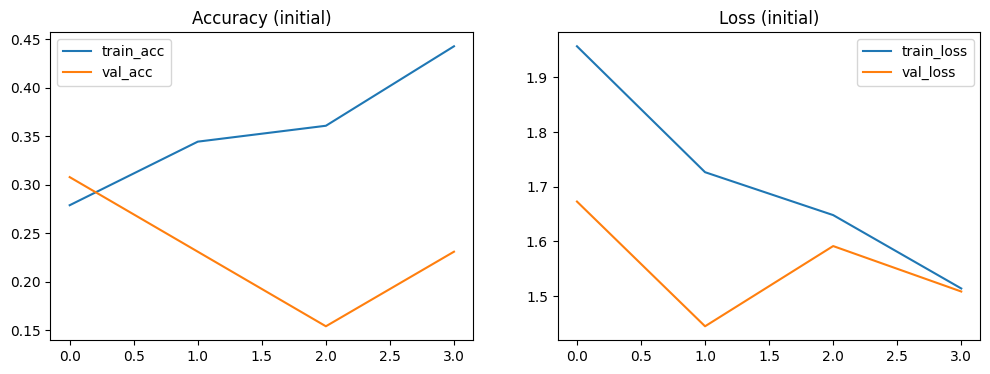

🟢 Plotted training curves (initial)


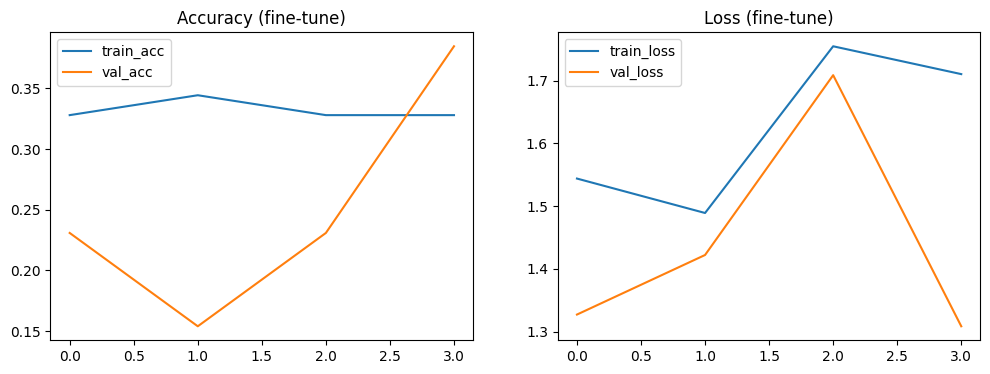

🟢 Plotted training curves (fine-tune)
🟢 Module 3 done. Exposed objects: history, fine_tune_history, model (trained).


In [21]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

EPOCHS = 4
BATCH_SIZE = 8
PATIENCE = 5
MODEL_SAVE_PATH = "/content/best_model.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=1)
]

train_pipeline = train_ds_aug.prefetch(tf.data.AUTOTUNE)
val_pipeline = val_ds.prefetch(tf.data.AUTOTUNE)

try:
    history = model.fit(
        train_pipeline,
        validation_data=val_pipeline,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    print("🟢 Initial training completed successfully.")
except Exception as e:
    print("❌ Training failed:", e)

print("\nStarting fine-tuning (unfreezing last layers)...")
try:
    unfreeze_model(model, n_unfreeze=50)
    fine_tune_history = model.fit(
        train_pipeline,
        validation_data=val_pipeline,
        epochs=4,
        callbacks=callbacks
    )
    print("🟢 Fine-tuning completed successfully.")
except Exception as e:
    print("🟡 Warning: Fine-tuning step encountered an issue:", e)

final_model_path = "/content/final_model.h5"
try:
    model.save(final_model_path)
    print("🟢 Saved final model to", final_model_path)
except Exception as e:
    print("🟡 Warning: Could not save final model:", e)

def plot_hist(h, title_suffix=""):
    try:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(h.history.get('accuracy', []), label='train_acc')
        plt.plot(h.history.get('val_accuracy', []), label='val_acc')
        plt.title("Accuracy " + title_suffix)
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(h.history.get('loss', []), label='train_loss')
        plt.plot(h.history.get('val_loss', []), label='val_loss')
        plt.title("Loss " + title_suffix)
        plt.legend()
        plt.show()
        print("🟢 Plotted training curves", title_suffix)
    except Exception as e:
        print("🟡 Warning: Could not plot training curves:", e)

plot_hist(history, "(initial)")
plot_hist(fine_tune_history, "(fine-tune)")

print("🟢 Module 3 done. Exposed objects: history, fine_tune_history, model (trained).")


🟢 Test Accuracy (multiclass): 0.3077

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00         3
meningioma_tumor       0.33      0.50      0.40         4
        no_tumor       0.00      0.00      0.00         2
 pituitary_tumor       0.67      0.50      0.57         4

        accuracy                           0.31        13
       macro avg       0.25      0.25      0.24        13
    weighted avg       0.31      0.31      0.30        13



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


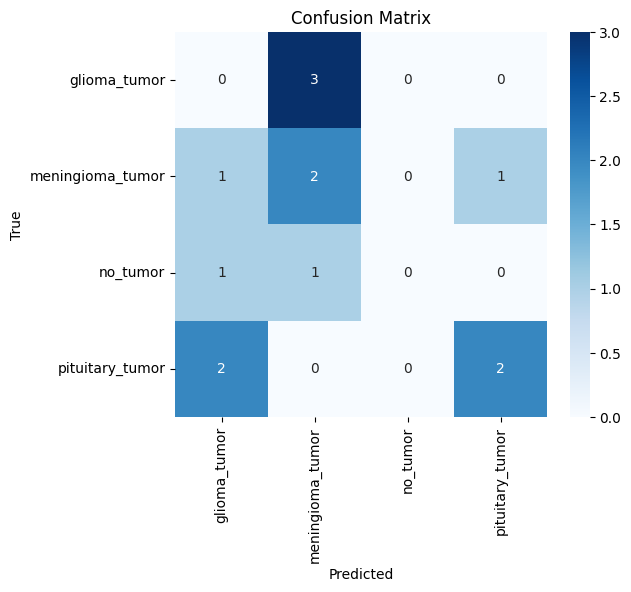

🟢 Using last conv layer for Grad-CAM: conv5_block16_2_conv


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_5976']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


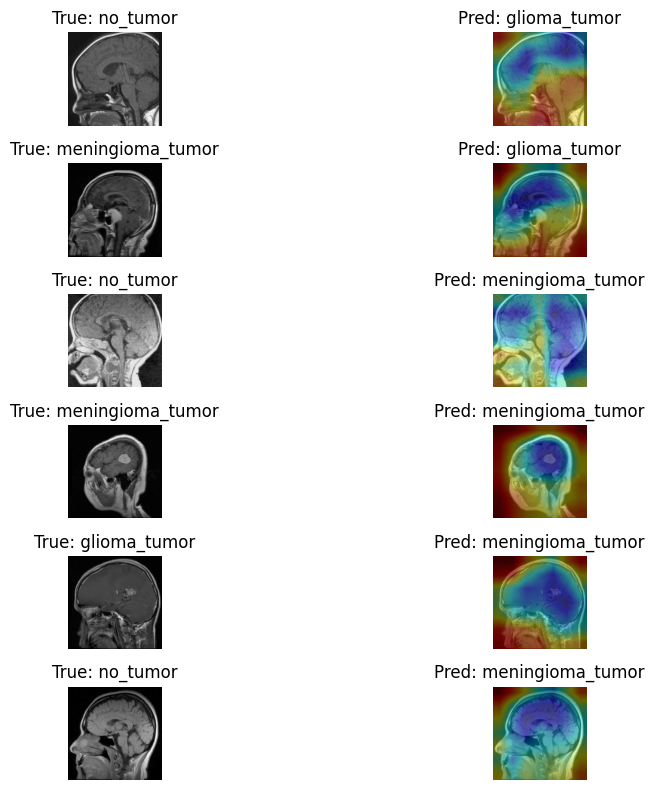

🟢 Module 4 complete: Evaluation metrics, Confusion Matrix, ROC (if binary), and Grad-CAM visualizations generated.


In [22]:
# ============================================================
# Module 4: Evaluation Engineer (Testing + Explainability)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
import cv2

y_true, y_pred, y_scores = [], [], []

for batch_images, batch_labels in test_ds:
    preds = model.predict(batch_images, verbose=0)
    if NUM_CLASSES == 2:
        scores = preds.reshape(-1)
        preds_thresh = (scores > 0.5).astype(int)
        y_scores.extend(scores.tolist())
        y_pred.extend(preds_thresh.tolist())
    else:
        scores = preds
        preds_arg = np.argmax(scores, axis=1)
        y_scores.extend(np.max(scores, axis=1).tolist())
        y_pred.extend(preds_arg.tolist())
    y_true.extend(batch_labels.numpy().tolist())

if NUM_CLASSES == 2:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"🟢 Test Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
else:
    acc = accuracy_score(y_true, y_pred)
    print(f"🟢 Test Accuracy (multiclass): {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap(heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
    return overlayed

try:
    base_model = model.get_layer('densenet121')
    last_conv_layer_name = None
    for layer in reversed(base_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    if last_conv_layer_name is None:
        raise ValueError("🔴 Could not find a Conv2D layer in DenseNet121.")
    print(f"🟢 Using last conv layer for Grad-CAM: {last_conv_layer_name}")
except Exception as e:
    print("🟡 Warning while locating last conv layer:", e)

num_to_show = 6
count = 0
plt.figure(figsize=(12, 8))

for batch_images, batch_labels in test_ds:
    batch_images_np = batch_images.numpy()
    preds = model.predict(batch_images, verbose=0)

    for i in range(len(batch_images_np)):
        if count >= num_to_show:
            break
        img = (batch_images_np[i] * 255).astype(np.uint8)
        img_input = np.expand_dims(batch_images_np[i], axis=0)
        if NUM_CLASSES == 2:
            score = model.predict(img_input, verbose=0).reshape(-1)[0]
            pred_index = 1 if score > 0.5 else 0
        else:
            pred_index = np.argmax(model.predict(img_input, verbose=0))
        heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name, pred_index)
        overlay = overlay_heatmap(heatmap, img)
        plt.subplot(num_to_show, 2, 2 * count + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[int(batch_labels[i])]}"); plt.axis('off')
        plt.subplot(num_to_show, 2, 2 * count + 2)
        plt.imshow(overlay)
        plt.title(f"Pred: {class_names[pred_index]}"); plt.axis('off')
        count += 1
    if count >= num_to_show:
        break

plt.tight_layout()
plt.show()

print("🟢 Module 4 complete: Evaluation metrics, Confusion Matrix, ROC (if binary), and Grad-CAM visualizations generated.")


🟢 Found model automatically: final_model.h5


🟢 Model 'final_model.h5' loaded successfully!

🟡 Upload MRI scan image(s) to test:


Saving m3 (61).jpg to m3 (61).jpg
Saving m3 (62).jpg to m3 (62).jpg
Saving m3 (63).jpg to m3 (63).jpg
Saving m3 (64).jpg to m3 (64).jpg

🟡 Testing 'm3 (61).jpg' ...


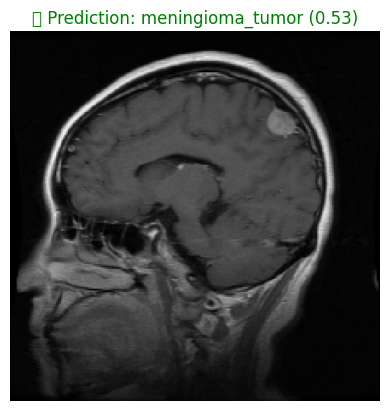

🟢 'm3 (61).jpg' → meningioma_tumor (0.53)


🟡 Testing 'm3 (62).jpg' ...


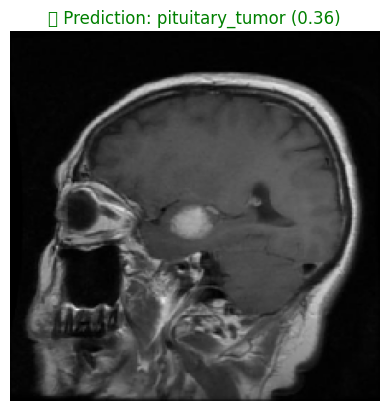

🟢 'm3 (62).jpg' → pituitary_tumor (0.36)


🟡 Testing 'm3 (63).jpg' ...


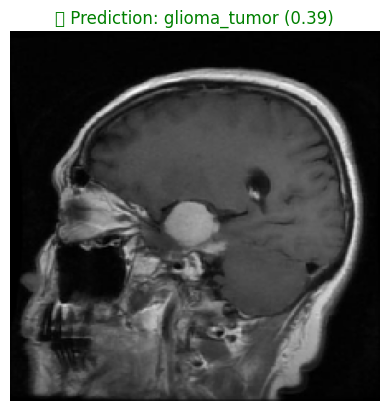

🟢 'm3 (63).jpg' → glioma_tumor (0.39)


🟡 Testing 'm3 (64).jpg' ...


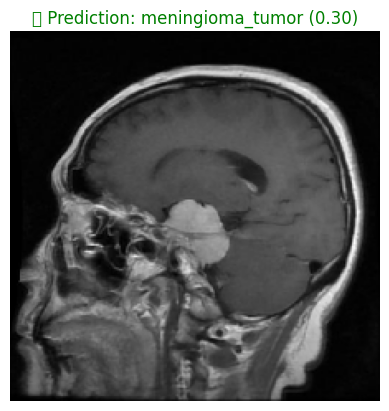

🟢 'm3 (64).jpg' → meningioma_tumor (0.30)



In [26]:
# ============================================
# 🧠 Brain Tumor MRI Detection - Testing Script
# Improved MRI validation with safe model-confidence fallback
# ============================================

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files
import os
import glob

# --- Config ---
CONFIDENCE_OVERRIDE_THRESHOLD = 0.85  # if model predicts with >= this confidence, accept image even if validator rejected
EDGE_DENSITY_THRESHOLD = 0.30        # relaxed edge density limit
COLOR_STD_THRESHOLD = 60.0           # relaxed color std limit
ASPECT_RATIO_MIN = 0.5
ASPECT_RATIO_MAX = 2.0
SHOW_BORDERLINE_PLOTS = True         # show image when borderline accepted

# --- Automatically detect and load model ---
h5_files = glob.glob("*.h5")
if not h5_files:
    print("\033[93m🟡 No .h5 model found in your environment. Please upload one.\033[0m")
    uploaded_model = files.upload()
    model_path = list(uploaded_model.keys())[0]
else:
    model_path = h5_files[0]
    print(f"\033[92m🟢 Found model automatically:\033[0m {model_path}")

# Load model
try:
    model = tf.keras.models.load_model(model_path)
    print(f"\033[92m🟢 Model '{model_path}' loaded successfully!\033[0m\n")
except Exception as e:
    print(f"\033[91m🔴 Failed to load model '{model_path}': {e}\033[0m")
    raise SystemExit

# --- Upload MRI image(s) ---
print("\033[93m🟡 Upload MRI scan image(s) to test:\033[0m")
uploaded_images = files.upload()

# --- Define class names ---
class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# --- Helper: Validate MRI-like image ---
def is_valid_mri(img_array):
    """
    Robust MRI-like validator.
    Returns: (valid: bool, reason: str, metric_dict: dict)
    """
    if img_array is None:
        return False, "image none", {}

    # Ensure we have a 3-channel image (convert grayscale to RGB)
    if img_array.ndim == 2:
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[-1] == 1:
        img_rgb = cv2.cvtColor(img_array[:, :, 0], cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img_array

    # Resize a working copy for analysis (keep aspect)
    h, w = img_rgb.shape[:2]
    small = cv2.resize(img_rgb, (256, int(256 * (h / w)))) if h >= w else cv2.resize(img_rgb, (int(256 * (w / h)), 256))

    # Grayscale & edge density
    gray = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 40, 120)  # softer Canny thresholds
    edge_density = float(np.sum(edges > 0)) / edges.size

    # Color statistics: MRI scans are often near-grayscale (low color variance)
    pixels = small.reshape(-1, 3)
    color_std = float(np.std(pixels, axis=0).mean())

    # Contrast: MRI often has moderate contrast (use CLAHE contrast measure)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_gray = clahe.apply(gray)
    contrast_score = float(np.std(clahe_gray))

    # Aspect ratio check (allow wider range)
    h0, w0 = img_rgb.shape[:2]
    aspect_ratio = float(max(h0 / w0, w0 / h0))

    metrics = {
        "edge_density": edge_density,
        "color_std": color_std,
        "contrast_score": contrast_score,
        "aspect_ratio": aspect_ratio,
        "orig_shape": (h0, w0)
    }

    # Rules (relaxed)
    if edge_density > EDGE_DENSITY_THRESHOLD:
        return False, "high_edge_density", metrics
    if color_std > COLOR_STD_THRESHOLD:
        return False, "high_color_std", metrics
    if aspect_ratio > ASPECT_RATIO_MAX or aspect_ratio < ASPECT_RATIO_MIN:
        return False, "bad_aspect_ratio", metrics

    # If all checks passed
    return True, "accepted", metrics

# --- Predict function with fallback ---
def predict_tumor(img_path):
    try:
        # Load image (PIL loader returns RGB)
        pil_img = image.load_img(img_path)
        img_array = np.array(pil_img)

        # Robust conversion to RGB if needed
        if img_array.ndim == 2:
            img_rgb_full = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        elif img_array.shape[-1] == 4:  # RGBA
            img_rgb_full = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
        else:
            img_rgb_full = img_array[..., :3]

        # Use validator on original-resolution image
        valid, reason, metrics = is_valid_mri(img_rgb_full)

        if not valid:
            # Prepare model input and get prediction confidence
            img_resized = image.load_img(img_path, target_size=(224, 224))
            img_input = np.expand_dims(np.array(img_resized) / 255.0, axis=0)
            preds = model.predict(img_input, verbose=0)
            if preds.ndim == 2 and preds.shape[1] > 1:
                pred_idx = int(np.argmax(preds[0]))
                confidence = float(np.max(preds[0]))
            else:
                pred_idx = int((preds.reshape(-1) > 0.5).astype(int)[0])
                confidence = float(preds.reshape(-1)[0])

            # If model is very confident, accept but mark as borderline (yellow)
            if confidence >= CONFIDENCE_OVERRIDE_THRESHOLD:
                label = class_names[pred_idx]
                if SHOW_BORDERLINE_PLOTS:
                    plt.imshow(img_resized)
                    plt.axis("off")
                    plt.title(f"🟡 Borderline accepted (by model): {label} ({confidence:.2f})", color="orange", fontsize=12)
                    plt.show()
                print(f"\033[93m🟡 '{os.path.basename(img_path)}' validation flagged ({reason}) but accepted due to high model confidence: {label} ({confidence:.2f})\033[0m\n")
                return
            else:
                # Reject and show reason
                plt.imshow(pil_img)
                plt.axis("off")
                plt.title("🔴 Invalid Image: Not an MRI scan", color="red", fontsize=12)
                plt.show()
                print(f"\033[91m🔴 '{os.path.basename(img_path)}' rejected: {reason} - metrics: {metrics}\033[0m\n")
                return

        # If valid, run prediction and show result
        img_resized = image.load_img(img_path, target_size=(224, 224))
        img_input = np.expand_dims(np.array(img_resized) / 255.0, axis=0)
        preds = model.predict(img_input, verbose=0)

        if preds.ndim == 2 and preds.shape[1] > 1:
            pred_idx = int(np.argmax(preds[0]))
            confidence = float(np.max(preds[0]))
        else:
            pred_idx = int((preds.reshape(-1) > 0.5).astype(int)[0])
            confidence = float(preds.reshape(-1)[0])

        label = class_names[pred_idx]
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"🟢 Prediction: {label} ({confidence:.2f})", fontsize=12, color="green")
        plt.show()
        print(f"\033[92m🟢 '{os.path.basename(img_path)}' → {label} ({confidence:.2f})\033[0m\n")

    except Exception as e:
        print(f"\033[91m🔴 Error processing '{img_path}': {e}\033[0m")

# --- Run predictions ---
for filename in uploaded_images.keys():
    print(f"\n\033[93m🟡 Testing '{filename}' ...\033[0m")
    predict_tumor(filename)
